In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
ptb_abnormal = pd.read_csv('/content/gdrive/MyDrive/data_kaggle/ptbdb_abnormal.csv', header=None)
ptb_normal = pd.read_csv('/content/gdrive/MyDrive/data_kaggle/ptbdb_normal.csv', header=None)

# Concatenation des deux DataFrames train & test 
ptb = pd.concat([ptb_normal, ptb_abnormal], ignore_index=True, sort=False)
ptb.rename(columns={187 :'class'}, inplace=True)

In [ ]:
# Datasets MITBIH train & test  
mit_train = pd.read_csv('/content/gdrive/MyDrive/data_kaggle/mitbih_train.csv', header=None)
mit_test = pd.read_csv('/content/gdrive/MyDrive/data_kaggle/mitbih_test.csv', header=None)

# Concatenation des deux DataFrames train & test 
mit = pd.concat([mit_train, mit_test], ignore_index=True, sort=False)
mit.rename(columns={187 :'class'}, inplace=True)

In [ ]:
mit['class'].replace({2:1,3:1,4:1}, inplace=True)
data = pd.concat([ptb, mit], ignore_index=True, sort=False)

In [ ]:
y = data['class']
X = data.drop('class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1,shuffle=True)

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('Classes échantillon oversampled :', dict(pd.Series(y_ro).value_counts()))

Classes échantillon oversampled : {0.0: 75645, 1.0: 75645}


187

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout, Flatten, Lambda
inputs = tf.keras.Input(shape=(X_ro.shape[1],))


expand = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand)
dense = tf.keras.layers.Dense(100, activation='relu')(gru)
flatten = tf.keras.layers.Flatten()(dense)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)
model = tf.keras.Model(inputs=inputs, outputs=outputs)






print(model.summary())


NameError: name 'X_ro' is not defined

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
    ]
)


history = model.fit(
    X_ro,
    y_ro,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        cp_callback,
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/2
3783/3783 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8233
Epoch 1: saving model to training_1/cp.ckpt
3783/3783 [==============================] - 44s 10ms/step - loss: 0.4020 - accuracy: 0.8233 - val_loss: 0.2990 - val_accuracy: 0.8691
Epoch 2/2
3781/3783 [============================>.] - ETA: 0s - loss: 0.2574 - accuracy: 0.8980
Epoch 2: saving model to training_1/cp.ckpt
3783/3783 [==============================] - 37s 10ms/step - loss: 0.2573 - accuracy: 0.8980 - val_loss: 0.5239 - val_accuracy: 0.7780


In [ ]:
y_pred = model.predict(X_test)
pd.crosstab(np.where(y_pred[:,0]> 0.5,1,0), y_test)

775/775 [==============================] - 4s 5ms/step


class,0.0,1.0
row_0,,
0,18797,229
1,193,5581


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.where(y_pred[:,0]> 0.5,1,0), y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19026
           1       0.96      0.97      0.96      5774

    accuracy                           0.98     24800
   macro avg       0.98      0.98      0.98     24800
weighted avg       0.98      0.98      0.98     24800



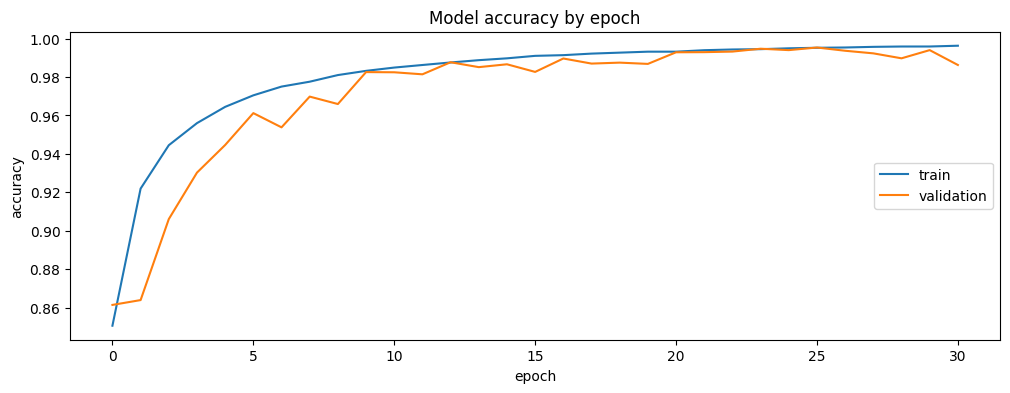

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
#plt.xlim(0,35)
plt.show()